In [1]:
!pip install skfda

ERROR: Could not find a version that satisfies the requirement skfda (from versions: none)
ERROR: No matching distribution found for skfda


In [1]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
url = 'https://raw.githubusercontent.com/asimxa/Data-Diggers-Project-Repo/refs/heads/main/resources/charging_sessions_cleaned.csv'
df = pd.read_csv(url)


In [3]:
df.columns

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'userID',
       'minutesAvailable', 'milesRequested', 'modifiedAt',
       'requestedDeparture', 'kWhRequested', 'WhPerMile', 'connectionDuration',
       'chargingDuration', 'noChargingTime', 'kWh_delivered_requested_diff'],
      dtype='object')

In [4]:
df.dtypes

,0
id,object
connectionTime,object
disconnectTime,object
doneChargingTime,object
kWhDelivered,float64
sessionID,object
siteID,int64
spaceID,object
stationID,object
userID,float64


In [5]:
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')
df['requestedDeparture'] = pd.to_datetime(df['requestedDeparture'], utc=True, errors='coerce')
df['connectionDuration'] = pd.to_timedelta(df['connectionDuration'])
df['chargingDuration'] = pd.to_timedelta(df['chargingDuration'])
df['noChargingTime']  = pd.to_timedelta(df['noChargingTime'])

In [6]:

# Convert 'connectionTime', 'disconnectTime', and 'doneChargingTime' to datetime objects
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col])

# Specify the target timezone
la_tz = pytz.timezone('America/Los_Angeles')

# Convert to Los Angeles timezone
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = df[col].dt.tz_convert(la_tz)

In [7]:
df.dtypes

,0
id,object
connectionTime,"datetime64[ns, America/Los_Angeles]"
disconnectTime,"datetime64[ns, America/Los_Angeles]"
doneChargingTime,"datetime64[ns, America/Los_Angeles]"
kWhDelivered,float64
sessionID,object
siteID,int64
spaceID,object
stationID,object
userID,float64


We'll start with some exploration. First, we standardize data. For the clustering algorithm to run correctly, we have to drop rows with NaN values

> Blockzitat einfügen



In [8]:
mean_charging_duration = df['chargingDuration'].dropna().mean()
mean_no_charging_time = df['noChargingTime'].dropna().mean()
df['chargingDuration'].fillna(mean_charging_duration, inplace=True)
df['noChargingTime'].fillna(mean_no_charging_time, inplace=True)

<ipython-input-8-e771532518ab>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['chargingDuration'].fillna(mean_charging_duration, inplace=True)
<ipython-input-8-e771532518ab>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [9]:
features = ["connectionDuration",
            "chargingDuration",
            "noChargingTime",
            "kWhDelivered"
            #"kWh_delivered_requested_diff"
            ]

X = df[features].copy()

# Drop rows with any missing values
#X.dropna(inplace=True)
# Convert timedelta64 columns to seconds
for col in ["connectionDuration", "chargingDuration", "noChargingTime"]:
    X[col] = X[col].dt.total_seconds()  # Access dt accessor and use total_seconds()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now we'll take a look at the Elbow plot

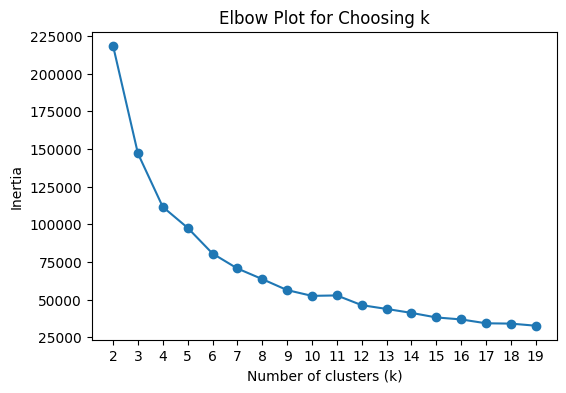

In [10]:
inertia_list = []
k_values = range(2, 20)  # test k from 2 to 9
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)


plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia_list, marker='o')
plt.title('Elbow Plot for Choosing k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

k=6 seems to be good, but for the fact that our recipients of the report are not necessarily data experts, we also aim for easy understandable modeling of clusters. Thus, we also take a look at k=3 and then compare

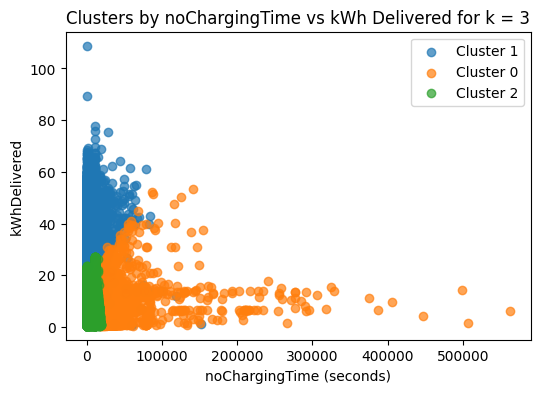

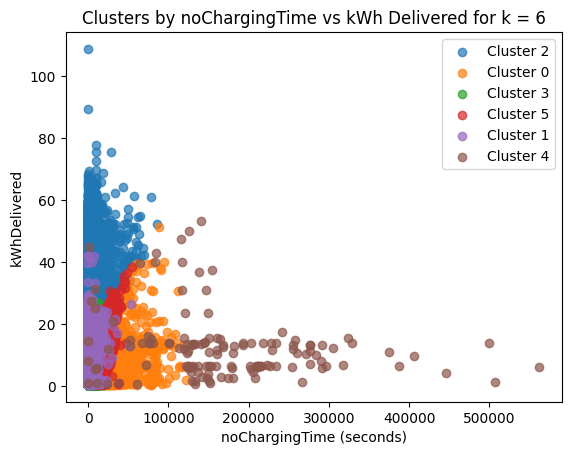

In [11]:
import matplotlib.pyplot as plt

# Let's do a simple 2D scatter by two features
feature_x = "noChargingTime"
feature_y = "kWhDelivered"

plt.figure(figsize=(6, 4))


#-----k = 3--------
k_opt = 3
X_3 = X
X_scaled_3 = scaler.fit_transform(X_3)
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42)
kmeans_opt.fit(X_scaled_3)

# Instead of assigning to df directly, create a new 'cluster' column in X

X_3['cluster_X3'] = kmeans_opt.labels_

# Merge the cluster labels back into the original DataFrame based on index
df = df.merge(X_3[['cluster_X3']], left_index=True, right_index=True, how='left')




# Merge the cluster labels back into the original DataFrame based on index
#df = df.merge(X_6[['cluster_X6']], left_index=True, right_index=True, how='left')
# We'll plot each cluster in a loop
for cluster_label in df['cluster_X3'].unique():
    cluster_data = df[df['cluster_X3'] == cluster_label]
    # Convert 'chargingDuration' to total seconds for plotting
    plt.scatter(
        cluster_data[feature_x].dt.total_seconds(),  # Convert to numeric (seconds)
        cluster_data[feature_y],
        label=f"Cluster {cluster_label}",
        alpha=0.7
    )

plt.title("Clusters by noChargingTime vs kWh Delivered for k = 3")
plt.xlabel(feature_x + " (seconds)") # Update x-axis label
plt.ylabel(feature_y)
plt.legend()
plt.show()
#------------for k=6--------
k_opt = 6
X_6 = X
X_scaled_6 = scaler.fit_transform(X_6)
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42)
kmeans_opt.fit(X_scaled_6)
# Instead of assigning to df directly, create a new 'cluster' column in X
X_6['cluster_X6'] = kmeans_opt.labels_
df = df.merge(X_6[['cluster_X6']], left_index=True, right_index=True, how='left')

for cluster_label in df['cluster_X6'].unique():
    cluster_data = df[df['cluster_X6'] == cluster_label]
    # Convert 'chargingDuration' to total seconds for plotting
    plt.scatter(
        cluster_data[feature_x].dt.total_seconds(),  # Convert to numeric (seconds)
        cluster_data[feature_y],
        label=f"Cluster {cluster_label}",
        alpha=0.7
    )

plt.title("Clusters by noChargingTime vs kWh Delivered for k = 6")
plt.xlabel(feature_x + " (seconds)") # Update x-axis label
plt.ylabel(feature_y)
plt.legend()
plt.show()

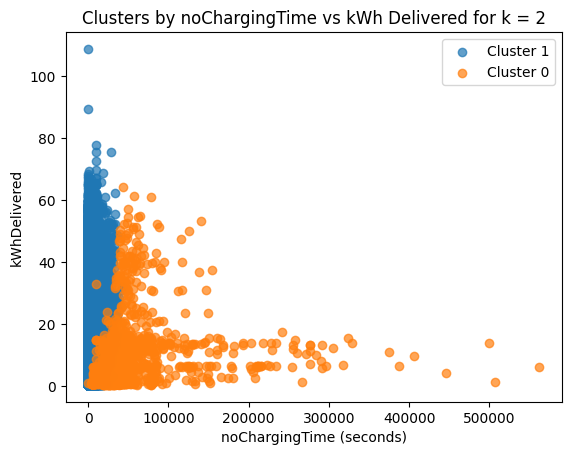

In [12]:
#------------for k=2--------
k_opt = 2
X_2 = X
X_scaled_2 = scaler.fit_transform(X_2)
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42)
kmeans_opt.fit(X_scaled_2)
# Instead of assigning to df directly, create a new 'cluster' column in X
X_6['cluster_X2'] = kmeans_opt.labels_
df = df.merge(X_6[['cluster_X2']], left_index=True, right_index=True, how='left')

for cluster_label in df['cluster_X2'].unique():
    cluster_data = df[df['cluster_X2'] == cluster_label]
    # Convert 'chargingDuration' to total seconds for plotting
    plt.scatter(
        cluster_data[feature_x].dt.total_seconds(),  # Convert to numeric (seconds)
        cluster_data[feature_y],
        label=f"Cluster {cluster_label}",
        alpha=0.7
    )

plt.title("Clusters by noChargingTime vs kWh Delivered for k = 2")
plt.xlabel(feature_x + " (seconds)") # Update x-axis label
plt.ylabel(feature_y)
plt.legend()
plt.show()

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
df

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture,kWhRequested,WhPerMile,connectionDuration,chargingDuration,noChargingTime,kWh_delivered_requested_diff,cluster_X3,cluster_X6,cluster_X2
0,5e23b149f9af8b5fe4b973cf,2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020-01-02 20:51:54+00:00,25.00,250.0,0 days 06:02:21,0 days 04:22:41,0 days 01:39:40,-0.016,1,2,1
1,5e23b149f9af8b5fe4b973d0,2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020-01-02 23:31:50+00:00,70.00,280.0,0 days 09:01:31,0 days 06:41:15,0 days 02:20:16,36.903,1,2,1
2,5e23b149f9af8b5fe4b973d1,2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020-01-02 14:56:35+00:00,8.00,400.0,0 days 10:42:47,0 days 02:38:31,0 days 08:04:16,1.479,0,0,0
3,5e23b149f9af8b5fe4b973d2,2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,...,2020-01-02 15:04:58+00:00,8.00,400.0,0 days 02:38:41,0 days 01:18:47,0 days 01:19:54,5.645,2,3,1
4,5e23b149f9af8b5fe4b973d3,2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,...,2020-01-02 22:24:01+00:00,16.00,400.0,0 days 08:08:39,0 days 04:17:29,0 days 03:51:10,2.625,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65032,5d2fbdd3f9af8b4d0dd0d54a,2019-07-01 14:49:12-07:00,2019-07-01 18:37:18-07:00,2019-07-01 16:14:33-07:00,8.399,1_1_179_798_2019-07-01 21:49:11.873404,1,AG-3F18,1-1-179-798,1346.0,...,2019-07-01 22:25:12+00:00,32.00,400.0,0 days 03:48:06,0 days 01:25:21,0 days 02:22:45,23.601,2,3,1
65033,5d2fbdd3f9af8b4d0dd0d54b,2019-07-01 14:58:45-07:00,2019-07-01 17:39:48-07:00,2019-07-01 17:40:21-07:00,16.864,1_1_179_794_2019-07-01 21:58:44.571011,1,AG-3F20,1-1-179-794,364.0,...,2019-07-02 01:52:45+00:00,40.00,400.0,0 days 02:41:03,0 days 02:41:36,0 days 00:00:33,23.136,2,3,1
65034,5d2fbdd3f9af8b4d0dd0d54c,2019-07-01 15:02:21-07:00,2019-07-01 17:58:50-07:00,2019-07-01 17:59:23-07:00,18.335,1_1_191_807_2019-07-01 22:02:20.810735,1,AG-4F47,1-1-191-807,2050.0,...,2019-07-02 03:11:21+00:00,29.97,333.0,0 days 02:56:29,0 days 02:57:02,0 days 00:00:33,11.635,2,3,1
65035,5d2fbdd3f9af8b4d0dd0d54d,2019-07-01 15:23:44-07:00,2019-07-01 19:03:36-07:00,2019-07-01 19:04:06-07:00,22.815,1_1_179_781_2019-07-01 22:23:32.496137,1,AG-3F31,1-1-179-781,1626.0,...,2019-07-02 00:02:44+00:00,34.00,200.0,0 days 03:39:52,0 days 03:40:22,0 days 00:00:30,11.185,2,3,1


In [15]:
X_scaled

array([[-0.04829567,  0.28768869, -0.30755904,  1.29213993],
       [ 0.56244117,  1.06615489, -0.13332218,  2.07831741],
       [ 0.90763531, -0.29751865,  1.34297043, -0.50718596],
       ...,
       [-0.68187123, -0.19349219, -0.732923  ,  0.64216446],
       [-0.53398769,  0.04995406, -0.73313758,  1.07801091],
       [-0.75601184, -0.5790736 , -0.53644162, -0.14527776]])

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
# Use X's original columns (before cluster columns were added)
original_columns = ["connectionDuration", "chargingDuration","noChargingTime","kWhDelivered"]
X_scaled_df = pd.DataFrame(X_scaled, columns=original_columns, index=X.index)
X_scaled_df["isUser"] = df["userID"].notnull()
X_scaled_df.head()

,connectionDuration,chargingDuration,noChargingTime,kWhDelivered,isUser
0,-0.048296,0.287689,-0.307559,1.292140,True
1,0.562441,1.066155,-0.133322,2.078317,True
2,0.907635,-0.297519,1.342970,-0.507186,True
3,-0.742547,-0.745460,-0.392389,-0.912484,True
4,0.382231,0.258475,0.256780,0.159620,True


In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled_df)
X_scaled_df['Cluster'] = clusters

In [18]:
X_scaled_df

,connectionDuration,chargingDuration,noChargingTime,kWhDelivered,isUser,Cluster
0,-0.048296,0.287689,-0.307559,1.292140,True,2
1,0.562441,1.066155,-0.133322,2.078317,True,2
2,0.907635,-0.297519,1.342970,-0.507186,True,0
3,-0.742547,-0.745460,-0.392389,-0.912484,True,1
4,0.382231,0.258475,0.256780,0.159620,True,0
...,...,...,...,...,...,...
65032,-0.505922,-0.708568,-0.122665,-0.324481,True,1
65033,-0.734480,-0.280197,-0.732923,0.499055,True,1
65034,-0.681871,-0.193492,-0.732923,0.642164,True,1
65035,-0.533988,0.049954,-0.733138,1.078011,True,1


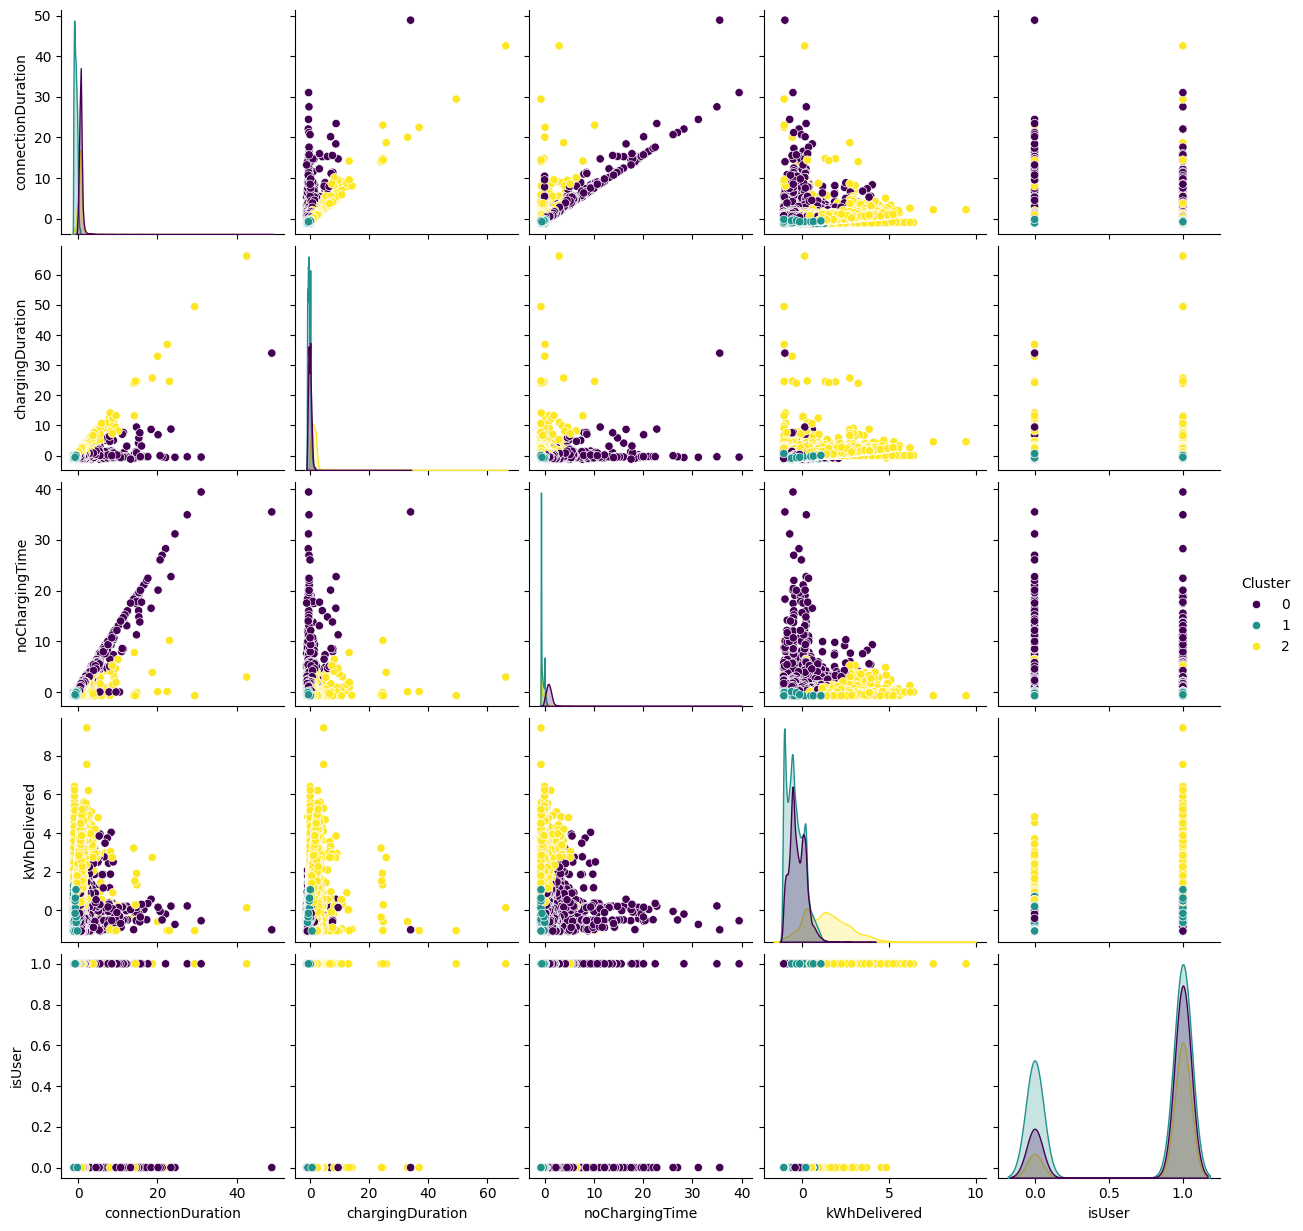

In [19]:
sns.pairplot(data=X_scaled_df, hue='Cluster', palette='viridis')

ERROR: Could not find a version that satisfies the requirement skfda (from versions: none)
ERROR: No matching distribution found for skfda
